# Pipeline ETL de datos del csv

## Extracción y transformación de los datos

In [1]:
import pandas as pd

# Cargar el archivo CSV
csv_path = "food_ingredients_and_allergens.csv"
df = pd.read_csv(csv_path)

# --- LIMPIEZA BÁSICA ---

# 1. Eliminar filas duplicadas
df.drop_duplicates(inplace=True)

# 2. Eliminar filas completamente vacías
df.dropna(how='all', inplace=True)

# 3. Eliminar espacios extra en nombres de columnas
df.columns = df.columns.str.strip()

# 4. Rellenar con "None" valores que son NaN en columnas clave
df.fillna(value={"Sweetener": "None", "Fat/Oil": "None", "Seasoning": "None"}, inplace=True)

# 5. Eliminar filas sin 'Food Product' o 'Main Ingredient' (esas no tienen sentido)
df = df[~df['Food Product'].isna() & ~df['Main Ingredient'].isna()]

# --- FIN LIMPIEZA BÁSICA ---

# Paso 1: Quitar la última columna (Prediction)
df = df.iloc[:, :-1]

# Diccionario de clasificación de macronutrientes por ingrediente principal
macro_dict = {
    # proteínas
    'chicken': 'proteins', 'beef': 'proteins', 'egg': 'proteins', 'cheese': 'proteins',
    'lentil': 'proteins', 'tofu': 'proteins', 'milk': 'proteins', 'paneer': 'proteins',
    'shrimp': 'proteins', 'salmon': 'proteins', 'fish': 'proteins', 'lamb': 'proteins',

    # grasas
    'almonds': 'fats', 'butter': 'fats', 'oil': 'fats', 'avocado': 'fats',
    'peanut': 'fats', 'nuts': 'fats',

    # carbohidratos
    'sugar': 'carbohydrates', 'flour': 'carbohydrates', 'rice': 'carbohydrates',
    'bread': 'carbohydrates', 'noodle': 'carbohydrates', 'pasta': 'carbohydrates',
    'potato': 'carbohydrates', 'corn': 'carbohydrates', 'oats': 'carbohydrates',
    'quinoa': 'carbohydrates', 'pizza dough': 'carbohydrates',

    # frutas (puedes agrupar como carbohidratos si buscas energía rápida)
    'apple': 'carbohydrates', 'banana': 'carbohydrates', 'mango': 'carbohydrates',
    'strawberry': 'carbohydrates', 'berries': 'carbohydrates',

    # verduras
    'spinach': 'carbohydrates', 'tomato': 'carbohydrates', 'zucchini': 'carbohydrates',
    'onion': 'carbohydrates', 'lettuce': 'carbohydrates', 'pumpkin': 'carbohydrates',
    'mushroom': 'carbohydrates', 'vegetable': 'carbohydrates', 'chickpeas': 'carbohydrates'
}


# Normalizar ingredientes principales para búsqueda
def clasificar_macro(ingrediente):
    if pd.isna(ingrediente):
        return 'unknown'
    ing = ingrediente.lower()
    for clave in macro_dict:
        if clave in ing:
            return macro_dict[clave]
    return 'other'

df["Main Macro"] = df["Main Ingredient"].apply(clasificar_macro)

# Paso 3: Clasificación calórica (por sweetener y fat/oil)
def clasificar_calorico(row):
    sweetener = str(row['Sweetener']).lower()
    fat = str(row['Fat/Oil']).lower()
    score = 0
    if any(s in sweetener for s in ['sugar', 'honey', 'syrup']):
        score += 1
    if any(f in fat for f in ['butter', 'oil', 'lard']):
        score += 1
    if score == 2:
        return 'high'
    elif score == 1:
        return 'medium'
    else:
        return 'low'

df["Caloric"] = df.apply(clasificar_calorico, axis=1)


#Paso 4: Clasificación dietética
restricciones_dieta = {
    "vegetarian": [
        "chicken", "beef", "pork", "fish", "shrimp", "gelatin", "lamb", "ham"
    ],
    "vegan": [
        "chicken", "beef", "pork", "fish", "shrimp", "ham"
        "milk", "cheese", "egg", "honey", "butter", "yogurt", "lamb", "gelatin"
    ],
    "keto": [
        "sugar", "flour", "bread", "rice", "potato", "pasta",
        "banana", "mango", "corn", "oats", "quinoa", "cake", "pastry"
    ],
    "diabetic": [
        "sugar", "honey", "syrup", "flour", "white bread", "white rice",
        "cake", "jam", "pastry", "sweetened condensed milk", "cookies"
    ],
    "halal": [
        "pork", "bacon", "lard", "alcohol", "ham", "gelatin", "liqueur"
    ],
    "kosher": [
        "pork", "shrimp", "shellfish", "bacon", "lobster", "crab", "ham", "prawns", "lobster"
    ]
}

def detectar_dietas(row):
    dietas = []

    main_ingredient = str(row["Main Ingredient"]).lower()
    sweetener = str(row["Sweetener"]).lower()
    fat = str(row["Fat/Oil"]).lower()
    seasoning = str(row["Seasoning"]).lower()
    allergens = str(row["Allergens"]).lower()
    macro = str(row["Main Macro"]).lower()
    caloric = str(row["Caloric"]).lower()

    for dieta, prohibidos in restricciones_dieta.items():
        no_apto = False

        # Revisa cada campo individualmente
        for item in [main_ingredient, sweetener, fat, seasoning]:
            if any(p in item for p in prohibidos):
                no_apto = True
                break

        # Revisa alérgenos directamente (ideal para kosher, halal, sin lactosa, etc.)
        if not no_apto:
            if any(p.lower() in allergens for p in prohibidos):
                no_apto = True

        # Reglas específicas
        if dieta == "diabetic" and macro == "carbohydrates" and caloric == "high":
            no_apto = True

        if dieta == "keto" and macro == "carbohydrates":
            no_apto = True

        if not no_apto:
            dietas.append(dieta)

    return ", ".join(dietas)



df["Diets"] = df.apply(detectar_dietas, axis=1)


# Exportar el csv preprocesado
df.to_csv("platos_preprocesados.csv", index=False)

# Mostrar las primeras filas
df.head()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,Food Product,Main Ingredient,Sweetener,Fat/Oil,Seasoning,Allergens,Main Macro,Caloric,Diets
0,Almond Cookies,Almonds,Sugar,Butter,Flour,"Almonds, Wheat, Dairy",fats,high,"vegetarian, halal, kosher"
2,Chicken Noodle Soup,Chicken broth,None,None,Salt,"Chicken, Wheat, Celery",proteins,low,"keto, diabetic, halal, kosher"
4,Cheddar Cheese,Cheese,None,None,Salt,Dairy,proteins,low,"vegetarian, keto, diabetic, halal, kosher"
5,Ranch Dressing,Buttermilk,Sugar,Vegetable oil,"Garlic, herbs",Dairy,proteins,high,"vegetarian, halal, kosher"
6,Caramel Popcorn,Popcorn,Sugar,Butter,Salt,Dairy,carbohydrates,high,"vegetarian, halal, kosher"


## Visualización de los datos


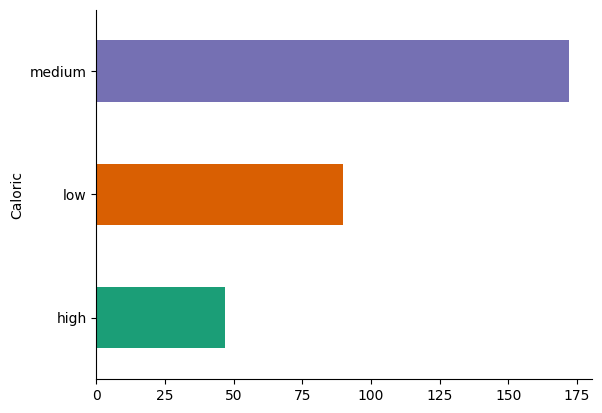

In [4]:
# @title Caloric

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Caloric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

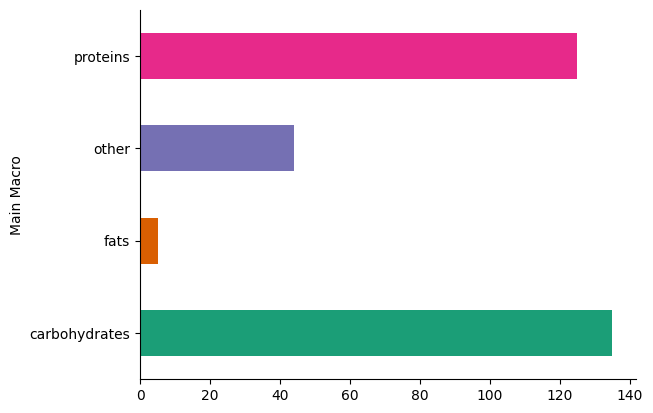

In [5]:
# @title Main Macro

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Main Macro').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Carga en la BD Neo4j


In [4]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
user = "neo4j"
password = "admin1234"  # prueba con esta

driver = GraphDatabase.driver(uri, auth=(user, password))

# Probar conexión
with driver.session() as session:
    result = session.run("RETURN 'Conexión exitosa' AS mensaje")
    print(result.single()["mensaje"])

Conexión exitosa


In [5]:
import pandas as pd

df = pd.read_csv("platos_preprocesados.csv")


In [6]:
def insertar_platos(tx, row):
    # Crear nodo de Plato
    tx.run("""
        MERGE (p:Plato {name: $name})
        SET p.macro = $macro, p.caloric = $caloric
    """, name=row["Food Product"], macro=row["Main Macro"], caloric=row["Caloric"])

    # Ingredientes (puedes ajustar según quieras crear uno por tipo)
    for col in ["Main Ingredient", "Sweetener", "Fat/Oil", "Seasoning"]:
        val = str(row[col]).strip()
        if val and val.lower() != "none":
            tx.run("""
                MERGE (i:Ingrediente {name: toLower($ing)})
                MERGE (p:Plato {name: $name})
                MERGE (p)-[:TIENE_INGREDIENTE]->(i)
            """, ing=val, name=row["Food Product"])

    # Alergenos
    if pd.notna(row["Allergens"]):
        for allergen in map(str.strip, row["Allergens"].split(",")):
            if allergen:
                tx.run("""
                    MERGE (a:Alérgeno {name: toLower($al)})
                    MERGE (i:Ingrediente {name: toLower($main_ing)})
                    MERGE (i)-[:ES_ALERGENO]->(a)
                """, al=allergen, main_ing=row["Main Ingredient"])

    # Dietas
    if pd.notna(row["Diets"]):
        for dieta in map(str.strip, row["Diets"].split(",")):
            if dieta:
                tx.run("""
                    MERGE (d:Dieta {name: toLower($dieta)})
                    MERGE (p:Plato {name: $name})
                    MERGE (p)-[:APTO_PARA]->(d)
                """, dieta=dieta, name=row["Food Product"])
                

In [7]:
with driver.session() as session:
    for _, row in df.iterrows():
        session.write_transaction(insertar_platos, row)
        

/tmp/ipykernel_14933/3840437396.py:3: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insertar_platos, row)
